In [28]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import unicodedata

nltk.download('omw-1.4')
%matplotlib inline

[nltk_data] Downloading package omw-1.4 to /home/mew/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
train_path = "data/train.csv/train.csv"
test_path = "data/test.csv/test.csv"
test_labels_path = "data/test_labels.csv/test_labels.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
train.drop('id', inplace=True, axis=1) #dropping id column
test.head

<bound method NDFrame.head of                       id                                       comment_text
0       00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1       0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2       00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3       00017563c3f7919a  :If you have a look back at the source, the in...
4       00017695ad8997eb          I don't anonymously edit articles at all.
...                  ...                                                ...
153159  fffcd0960ee309b5  . \n i totally agree, this stuff is nothing bu...
153160  fffd7a9a6eb32c16  == Throw from out field to home plate. == \n\n...
153161  fffda9e8d6fafa9e  " \n\n == Okinotorishima categories == \n\n I ...
153162  fffe8f1340a79fc2  " \n\n == ""One of the founding nations of the...
153163  ffffce3fb183ee80  " \n :::Stop already. Your bullshit is not wel...

[153164 rows x 2 columns]>

### checking for null entries

In [4]:
train.isnull().any(),test.isnull().any()

(comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id              False
 comment_text    False
 dtype: bool)

### correlation between labels

<AxesSubplot:>

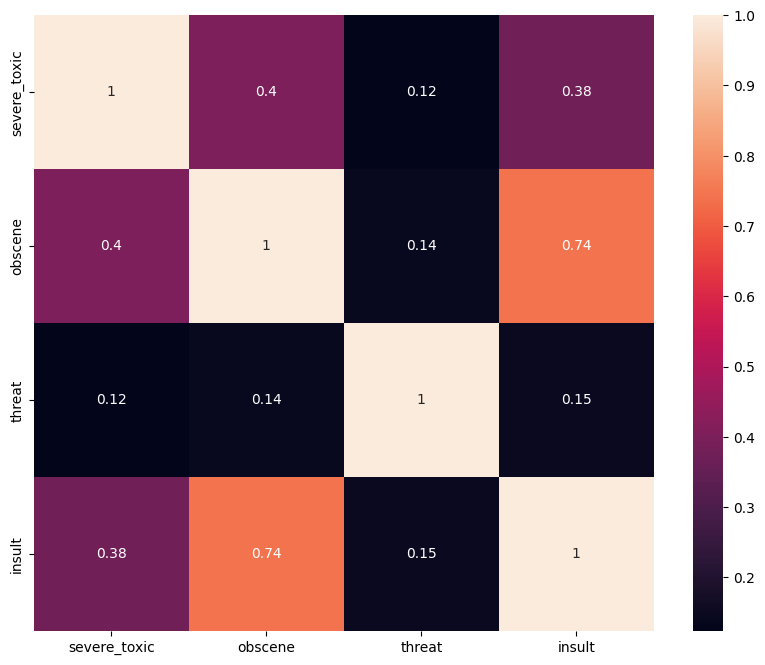

In [5]:
temp_df=train.iloc[:,2:-1]
corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [6]:
train.dtypes

comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

### Preprocessing

    Lower case
    removing accented characters
    removing punctuation
    removing irrelevant characters
    removing extra whitespaces

In [7]:
def rem_accented(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
def rem_puntucation(text):
    pat = r'[^a-zA-Z0-9;\"\'\s]'
    return re.sub(pat, '',text)
def get_long(text):
    text = re.sub(r"can't", "can not",text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'s", " is ", text)
    return text
def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!"?/:;\"\'\s]' 
    return re.sub(pat, '', text)
    
# stopwords
stops = stopwords.words("english") 
delete = ['no',
'nor',
'not',
'don',
"don't",
'ain',
'aren',
"aren't",
'couldn',
"couldn't",
'didn',
"didn't",
'doesn',
"doesn't",
'hadn',
"hadn't",
'hasn',
"hasn't",
'haven',
"haven't",
'isn',
"isn't",
'ma',
'mightn',
"mightn't",
'mustn',
"mustn't",
'needn',
"needn't",
'shan',
"shan't",
'shouldn',
"shouldn't",
'wasn',
"wasn't",
'weren',
"weren't",
'won',
"won't",
'wouldn',
"wouldn't"]
new = [stop for stop in stops if stop not in delete]

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# def get_lemmatization(text):
#     return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

def get_lemmatization(text):
    # Tokenize: Split the sentence into words
    word_list = nltk.word_tokenize(text)
    # Lemmatize list of words and join
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

In [8]:
def preprocess(df):
    df['comment_text'] = df['comment_text'].astype(str)
    df['clean_comment'] = df['comment_text'].str.lower()
    df['clean_comment'] = df['clean_comment'].apply(rem_puntucation)
    df['clean_comment'] = df['clean_comment'].apply(get_long)
    df['clean_comment'] = df['clean_comment'].apply(remove_special_characters)
    df['clean_comment'] = df['clean_comment'].apply(lambda x: ' '.join([item for item in x.split() if item not in new]))
    df['clean_comment'] = df['clean_comment'].apply(rem_accented)
    df['clean_comment'] = df['clean_comment'].apply(get_lemmatization)
    return df

In [10]:
train = preprocess(train)

In [16]:
train.head(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comment
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww match background colour seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man really not trying edit war guy constan...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,`` not make real suggestion improvement wonder...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page


In [19]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
ytrain = train[list_classes].values
Xtrain = train["clean_comment"]

In [20]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(Xtrain))
X_tokenized_train = tokenizer.texts_to_sequences(Xtrain)
X_tokenized_test = tokenizer.texts_to_sequences(Xtest)

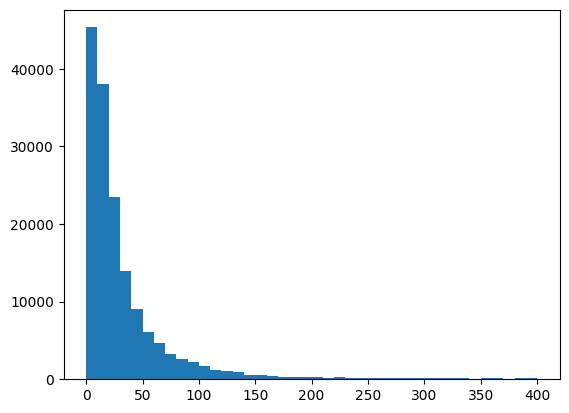

In [21]:
totalNumWords = [len(one_comment) for one_comment in X_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.show()

In [22]:
maxlen = 200
X_t = pad_sequences(X_tokenized_train, maxlen=maxlen)

In [23]:
inp = Input(shape=(maxlen, ))
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
print(model.summary())

2022-09-12 23:57:50.699926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-12 23:57:50.740638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib
2022-09-12 23:57:50.740672: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Ski

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 lstm_layer (LSTM)           (None, 200, 60)           45360     
                                                                 
 global_max_pooling1d (Globa  (None, 60)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                             

In [24]:
batch_size = 32
epochs = 1
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=2,restore_best_weights=True)
history = model.fit(X_t,ytrain, batch_size=batch_size, epochs=epochs,callbacks=[callback], validation_split=0.1,shuffle=True)

4488/4488 [==============================] - 819s 182ms/step - loss: 0.0727 - accuracy: 0.9560 - val_loss: 0.0519 - val_accuracy: 0.9940


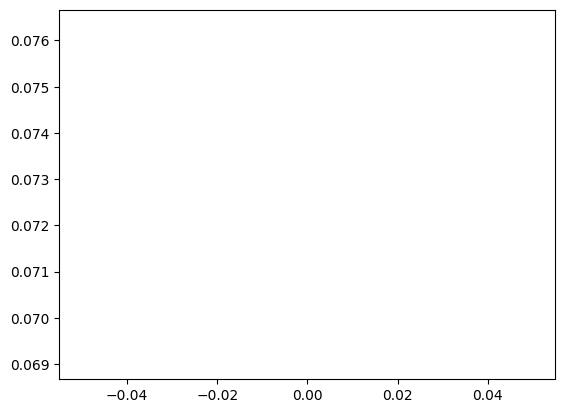

In [25]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [26]:
!mkdir -p saved_model
model.save('saved_model/model1')

INFO:tensorflow:Assets written to: saved_model/model1/assets


INFO:tensorflow:Assets written to: saved_model/model1/assets


In [31]:
model = tf.keras.models.load_model('saved_model/model1')

### predicting for test set

In [45]:
test = preprocess(test)
X_tokenized_test = tokenizer.texts_to_sequences(test['clean_comment'])
X_te = pad_sequences(X_tokenized_test, maxlen=maxlen)
y_pred = model.predict(X_te,batch_size=1024,verbose=1)

150/150 [==============================] - 72s 480ms/step


In [47]:
submission = pd.read_csv('./data/sample_submission.csv/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission.csv', index=False)